# Gene sorting by KEGG functional annotations (TreeMap)
This notebook is based on the paper *OmicsMapNet: Transforming omics data to take advantage of Deep Convolutional Neural Network for discovery*, whose authors are *Shiyong Ma, Zhen Zhang* (https://arxiv.org/ftp/arxiv/papers/1804/1804.05283.pdf)
- Paper summary: 
Their aim was to rearrange high-dimensional omics data as 2-dimensional images, and train a Keras-CNN with them. For that, they used KEGG database which provides functional anotation of genes. Specifically, KEGG BRITE captures 'the functional hierarchies of biological objects'. And based on this hierarchy, each omic vector was shaped as an image using a treemap.

In [1]:
#libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import squarify 

###  KEGG and TCGA data loading

- Data coming from KEGG database is fetched on 'KEGG_Data_obtaining.ipynb' notebook
- Data coming from TCGA database is fetched on 'TCGA_Data_obtaining.ipynb' notebook

In [ ]:
# KEGG
hsa = pd.read_csv('../data/KEGG/KEGG_gene_hsa.csv', sep='\t'  , engine='python', header=None, index_col=0)
hsa_brite = pd.read_csv('../data/KEGG/KEGG_hsa_brite.csv', sep='\t'  , engine='python', header=None)
hsa_brite.columns = ['keggBriteId', 'keggId']
brite = pd.read_csv('../data/KEGG/KEGG_brite.csv', engine='python', header=0, index_col=0)

# TCGA

# pp_df_gene_exp = pd.read_hdf("data/preprocessed1_expr.h5", key='expression') # only selected features
# df_gene_exp = pd.read_hdf("data/TCGA_data.h5", key='both_gene_expression') # all

brca_ex = pd.read_hdf("/mnt/ext/almacen/comun/Francis/almacen/DeepLearning-Bioinformatics/data/PanCancer/mad_filter_pancan_all_TCGA_20.h5", key = "brca")
non_brca_ex = pd.read_hdf("/mnt/ext/almacen/comun/Francis/almacen/DeepLearning-Bioinformatics/data/PanCancer/mad_filter_pancan_all_TCGA_20.h5", key = "non_brca")

In [ ]:
hsa_brite['keggBriteId'] = [br_id[7:] for br_id in hsa_brite['keggBriteId']]

In [ ]:
brite_homosap_index = list(set(brite['keggBriteId']).intersection(set(hsa_brite['keggBriteId'])))

In [ ]:
brite = brite.loc[brite['keggBriteId'].isin(brite_homosap_index)]

In [ ]:
ens_genes = brca_ex.columns

In [ ]:
print("Initial number of genes: {}".format(len(ens_genes)))

In [ ]:
print("Total number of samples (patients): {}".format(brca_ex.shape[0]+non_brca_ex.shape[0]))

## MAPPING: From Ensembl Gene ID to KEGG BRITE functional annotation
KEGG relates Hugo-gene-names to an internal id (KEGG id) that is useful to find out the corresponding KEGG BRITE value/s (hierarchical functional annotations) of each gene.
Due to genes in TCGA are indexed by Ensembl-ids, it is needed mapping Ensembl-id to Hugo-gene-name

All the code below (mappings) can be ignored until next section just loading 'gene_mapping' DataFrame, which contains mapping from Ensembl id to KEGG Brite

In [ ]:
# Loading 'gene_mapping' DataFrame
gene_mapping = pd.read_hdf('../data/KEGG/map_ens_kegg_brite.h5', key='map')

### Mapping: Ensembl Gene ID to  Hugo Gene Name
Down below, it is downloaded a table relating ensembl-ids and hugo-gene-names from this URL: https://raw.githubusercontent.com/jvivian/docker_tools/master/gencode_hugo_mapping/attrs.tsv

In [ ]:
%%time

url = 'https://raw.githubusercontent.com/jvivian/docker_tools/master/gencode_hugo_mapping/attrs.tsv'
hugo_request = requests.get(url, allow_redirects=True)
open('../data/hugo_ensembl.tsv', 'wb').write(hugo_request.content)
del hugo_request

In [ ]:
hugo_ens = pd.read_csv('../data/hugo_ensembl.tsv', sep='\t', engine='python', index_col=0)

In [ ]:
hugo_ens = hugo_ens[~hugo_ens.index.duplicated()]

common_genes = hugo_ens.index.intersection(ens_genes)
hugo_ens = hugo_ens.loc[common_genes, :]

len(common_genes)

In [ ]:
hugo_ens

In [ ]:
gene_mapping = pd.DataFrame(hugo_ens.loc[:,'geneName'])

In [ ]:
gene_mapping['ensId'] = gene_mapping.index

In [ ]:
gene_mapping['geneName']

### Mapping: Hugo Gene Name to KEGG gene id

In [ ]:
hsa_hugo_dict = dict()
for i in range(0, len(hsa)):
    value = hsa.loc[hsa.index[i],1].split(";")[0].split(',')
    if 'uncharacterized' not in value[0] and len(value[0])<20:
        hsa_hugo_dict[hsa.index[i]] = value

In [ ]:
len(hsa_hugo_dict)

In [ ]:
%%time
hsa_hugo = pd.DataFrame(columns=['keggId','geneName'])
i = 0
for key, values in hsa_hugo_dict.items():
    for ens in values:
        hsa_hugo.loc[i] = [key, ens]
        i+=1

In [ ]:
hsa_hugo.shape

In [ ]:
gene_mapping = pd.merge(gene_mapping, hsa_hugo, on='geneName')

### Mapping: KEGG gene id to KEGG BRITE id

In [ ]:
gene_mapping

In [ ]:
len(set(hsa_brite['keggId'].value_counts().index).intersection(gene_mapping['keggId']))

In [ ]:
gene_mapping = pd.merge(gene_mapping, hsa_brite, on='keggId')

In [ ]:
gene_mapping

### Mapping: KEGG BRITE id to KEGG BRITE functional annotation

In [ ]:
gene_mapping = pd.merge(gene_mapping, brite, on='keggBriteId')

In [ ]:
brite

In [ ]:
gene_mapping

## Mapping: KEGG BRITE functional annotation to KEGG BRITE group of functional annotations

### Mapping: exporting gene_mapping DataFrame

In [ ]:
with pd.HDFStore('../data/KEGG/map_ens_kegg_brite.h5') as store:
    store['map'] = gene_mapping

# KEGG-TREEMAPs generation

From genetic expression profiles data, along with the information obtained from KEGG database, treemap images are generated. This is done by using 'treemap' R package.

A treemap is a rectangular displaying for hierarchical data visualization. 

In our case, all genes are represented as squares of size 1 and colored according to their expresion level. Genes are grouped and placed in the treemap according to each functional annotation subgroup (ie. 'RNA family' or 'Orthologs and modules') and functional annotation (ie. 'Translation factors' or 'Non-coding RNAs'). Inside of each hierarchy, genes are sorted by their mean for all samples.

In [ ]:
exp_to_tree_map = pd.concat([non_brca_ex, brca_ex]).T
exp_to_tree_map['ensId'] = exp_to_tree_map.index
exp_to_tree_map['tamPixel'] = np.ones(exp_to_tree_map.shape[0])
exp_to_tree_map['order'] = pd.concat([non_brca_ex, brca_ex]).mean() # order genes in the map by mean expression level
exp_to_tree_map = pd.merge(gene_mapping, exp_to_tree_map, on='ensId')

In [ ]:
with open('genes_remaining.txt', 'w') as f:
    f.write(str(set(exp_to_tree_map.ensId)))

In [ ]:
len(set(exp_to_tree_map.ensId))

In [ ]:
len((exp_to_tree_map.ensId))

In [ ]:
import ast
with open('../common_genes_1-5.txt','r') as f:
   common_1_5 = ast.literal_eval(f.read())

In [ ]:
exp_to_tree_map = exp_to_tree_map.loc[exp_to_tree_map['ensId'].isin(common_1_5)]

In [ ]:
exp_to_tree_map.shape

In [ ]:
len(set(exp_to_tree_map.ensId))

In [ ]:
exp_to_tree_map.columns[9810]

In [ ]:
%%time
exp_to_tree_map.to_csv('COMMON_GENES_exp_to_KEGG_tree_map.csv')

In [2]:
exp_to_tree_map = pd.read_csv('COMMON_GENES_exp_to_KEGG_tree_map.csv')

In [3]:
exp_to_tree_map.shape

(3619, 10545)

In [4]:
len(set(exp_to_tree_map.ensId))

1492

In [5]:
exp_to_tree_map['Functional Annotation Group'].value_counts()

Genes and Proteins    3619
Name: Functional Annotation Group, dtype: int64

In [6]:
subgroups = exp_to_tree_map['Functional Annotation Subgroup'].value_counts()

In [10]:
len(exp_to_tree_map['Functional Annotation'].value_counts())

37

In [7]:
subgroups

Orthologs and modules                                 1492
Protein families: signaling and cellular processes    1138
Protein families: genetic information processing       516
Protein families: metabolism                           473
Name: Functional Annotation Subgroup, dtype: int64

In [8]:
for sub in subgroups.index:
    print(sub.upper())
    print(exp_to_tree_map[exp_to_tree_map['Functional Annotation Subgroup'] == sub]['Functional Annotation'].value_counts())

ORTHOLOGS AND MODULES
KEGG Orthology (KO)    1492
Name: Functional Annotation, dtype: int64
PROTEIN FAMILIES: SIGNALING AND CELLULAR PROCESSES
Exosome                                                 195
G protein-coupled receptors                             161
Cytokines and growth factors                            158
CD molecules                                            156
Glycosaminoglycan binding proteins                       97
Ion channels                                             79
Cytokine receptors                                       73
Cytoskeleton proteins                                    59
Cell adhesion molecules                                  41
Transporters                                             31
GTP-binding proteins                                     24
Lectins                                                  19
Glycosylphosphatidylinositol (GPI)-anchored proteins     15
Nuclear receptors                                        11
Proteoglycans    

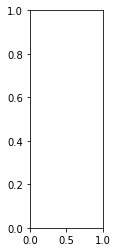

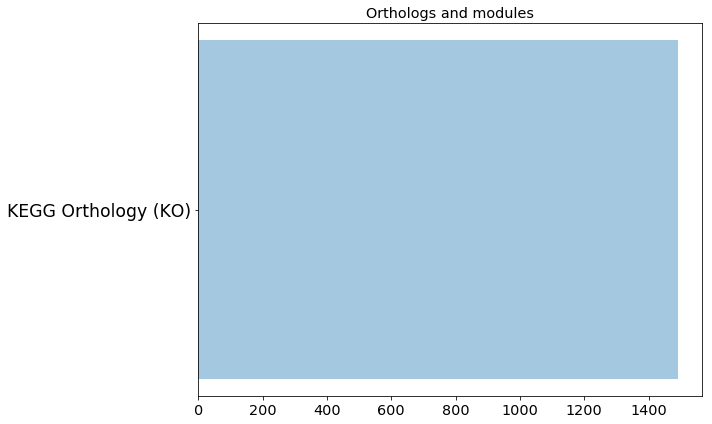

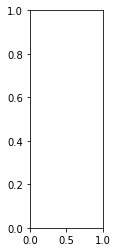

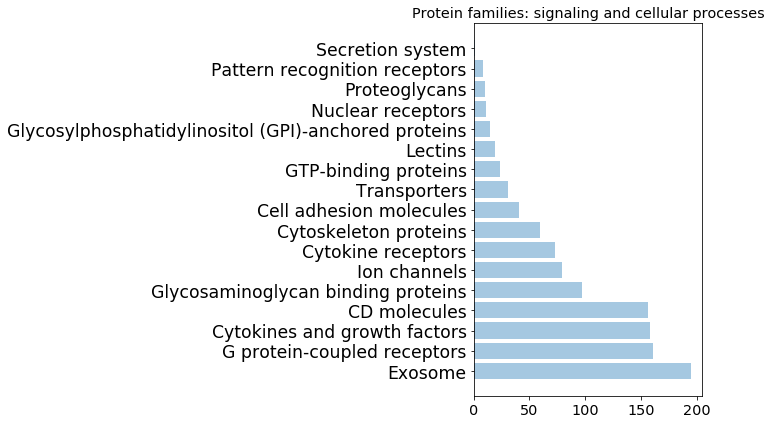

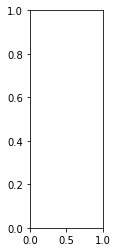

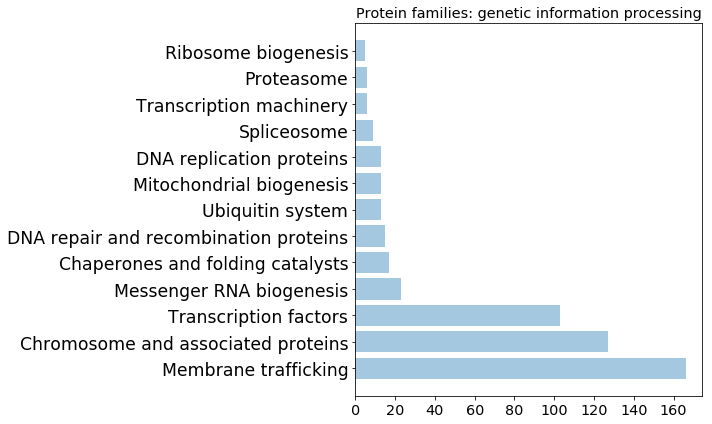

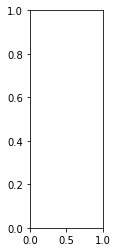

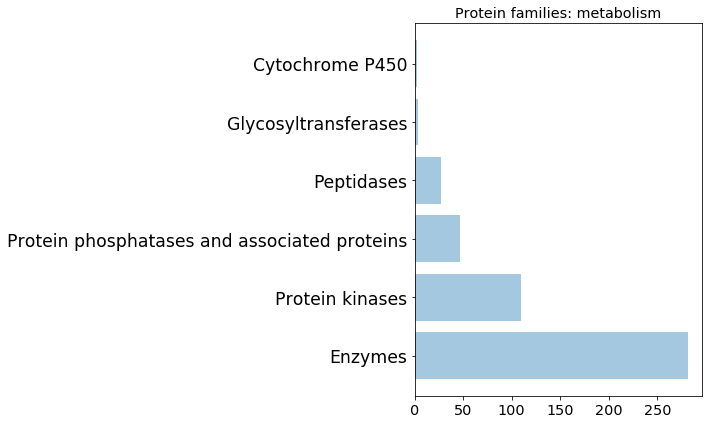

In [32]:
import matplotlib.pyplot as plt

%matplotlib inline

# plot
for i in range(0,4):
    data = exp_to_tree_map[exp_to_tree_map['Functional Annotation Subgroup'] == subgroups.index[i]]['Functional Annotation'].value_counts()
    names = data.index
    values = data
    plt.subplot(1,4,i+1)
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    yvals = range(len(names))
    a = ax.barh(yvals, values, align='center', alpha=0.4)
    plt.title(subgroups.index[i], fontsize='x-large')
    plt.yticks(yvals,names, fontsize='xx-large')
    plt.xticks(fontsize='x-large')
    plt.tight_layout()

    plt.show()

In [ ]:
import matplotlib.pyplot as plt


py.offline.init_notebook_mode()

names = myindexes

values = mylist

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
yvals = range(len(names))
ax.barh(yvals, values, align='center', alpha=0.4)
plt.yticks(yvals,names)
plt.tight_layout()
plt.xlabel('Number of genes', fontsize=18)
plt.ylabel('Chromosome', fontsize=18)

plt.show()

In [ ]:
import plotly as py
import plotly.graph_objs as go

py.offline.init_notebook_mode()

subgroups_counts = exp_to_tree_map['Functional Annotation Subgroup'].value_counts()

labels = subgroups_counts.index
values = subgroups_counts

trace = go.Pie(labels=labels, values=values)

py.offline.iplot([trace], filename='basic_pie_chart')

In [ ]:
exp_to_tree_map['Functional Annotation'].value_counts()

http://rpy.sourceforge.net/rpy2/doc-2.4/html/interactive.html

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R

source('Gene_KEGG_treemap_generator.R')

# Convolutional neural network for predicting cancer survival

In this notebook, a CNN is trained for cancer survival prediction with the following structure:

- input: gene expression profiles shape an image (as a matrix) per patient, whose pixels (gene expression levels) are neigbours depending on their KEGG-BRITE functional annotation. These are the previously generated treemap-images.

- output: the correspondant Kaplan-Meier curve (as a vector) per patient, in that way it would be predicted survival for a discrete range of time.


## Input: KEGG-TREEMAPs

Previously generated treemap images are going to be used as input of a convolutional neural network, in order to 

### KEGG-TREEMAPs data loading

In [ ]:
%%time

# DL with Python - François Chollet (pp. 162-163)
from PIL import Image
from keras.preprocessing import image
import glob

path = '../data/KEGG/COMMON_GENES_KEGG_TREEMAPS/'
filelist = glob.glob(path + '*.png')
brca_images = dict()
non_brca_images = dict()
w, h = (480, 480)
basewidth = 100
wpercent = (basewidth/float(w))
hsize = int((float(h)*float(wpercent)))
for filename in filelist:
    sample = filename.split(" ")[1]
    if('NON' in sample):
        non_brca_images[sample.split("_")[0].replace('.','-')] = image.load_img(filename).crop((11, 11, w-13, h-13)).resize((basewidth,hsize), Image.ANTIALIAS)
    else:
        brca_images[sample.split("_")[0].replace('.','-')] = image.load_img(filename).crop((11, 11, w-13, h-13)).resize((basewidth,hsize), Image.ANTIALIAS)

In [ ]:
image.img_to_array(non_brca_images[list(non_brca_images.keys())[9]]).shape

In [ ]:
non_brca_images[list(non_brca_images.keys())[911]]

In [ ]:
len(non_brca_images)

In [ ]:
len(brca_images)

## Output: Discrete time survival vector

### Overal Survival (OS) data loading and cleaning

In [ ]:
brca_clinical = pd.read_hdf('data/TCGA_data.h5', key='brca_clinical')
non_brca_clinical = pd.read_hdf('data/TCGA_data.h5', key='non_brca_clinical')

BRCA:

In [ ]:
print("Number of brca-samples with clinical information: {}".format(len(brca_clinical.index)))

In [ ]:
brca_clinical['OS'].value_counts()

In [ ]:
brca_clinical['OS.time'].value_counts()

NON-BRCA:

In [ ]:
print("Number of non_brca-samples with clinical information: {}".format(len(non_brca_clinical.index)))

In [ ]:
non_brca_clinical['OS'].value_counts()

In [ ]:
non_brca_clinical['OS.time'].value_counts()

Both brca and non_brca clinical data have NaN values in OS-columns. Also, there are samples that are not in both clinical and image datasets. Because of these problems, it is necessary to drop some samples we do not have all required information of.

In [ ]:
# Deleting samples with 'NaN's in OS-columns 

## non_brca
non_brca_clinical['OS.time'] = non_brca_clinical['OS.time'].map(lambda x: np.nan if x == 'NaN' else x)
non_brca_clinical['OS'] = non_brca_clinical['OS'].map(lambda x: np.nan if x == 'NaN' else x)
non_brca_clinical.dropna(subset=['OS.time', 'OS'], inplace=True)
non_brca_clinical['OS.time'] = non_brca_clinical['OS.time'].astype(float)
non_brca_clinical['OS'] = non_brca_clinical['OS'].astype(float)

## brca
brca_clinical['OS.time'] = brca_clinical['OS.time'].map(lambda x: np.nan if x == 'NaN' else x)
brca_clinical['OS'] = brca_clinical['OS'].map(lambda x: np.nan if x == 'NaN' else x)
brca_clinical.dropna(subset=['OS.time', 'OS'], inplace=True)
brca_clinical['OS.time'] = brca_clinical['OS.time'].astype(float)
brca_clinical['OS'] = brca_clinical['OS'].astype(float)

In [ ]:
common_brca = set(list(brca_images.keys())).intersection(brca_clinical.index)
for sample in list(brca_images.keys()):
    if(sample not in common_brca): del brca_images[sample] 
brca_clinical = brca_clinical.loc[common_brca]

common_non_brca = set(list(non_brca_images.keys())).intersection(non_brca_clinical.index)
for sample in list(non_brca_images.keys()):
    if(sample not in common_non_brca): del non_brca_images[sample] 
non_brca_clinical = non_brca_clinical.loc[common_non_brca]

In [ ]:
print("Number of brca samples after cleaning: {}".format(len(list(brca_images.keys()))))

In [ ]:
print("Number of brca samples after cleaning: {}".format(len(list(brca_images.keys()))))

In [ ]:
print("Number of non_brca samples after cleaning: {}".format(len(list(non_brca_images.keys()))))

In [ ]:
print("Number of non_brca samples after cleaning: {}".format(len(list(non_brca_images.keys()))))

### From OS to 

In [ ]:
# Create 39 equally spaced intervals for follow-up time, from 0 to 5 years:
breaks = np.arange(0.,365.*5,365./8)
n_intervals = len(breaks)-1
timegap = breaks[1:] - breaks[:-1]

In [ ]:
import nnet_survival

In [ ]:

non_brca_y = nnet_survival.make_surv_array(non_brca_clinical['OS.time'],
                             non_brca_clinical['OS'],
                             breaks)
brca_y = nnet_survival.make_surv_array(brca_clinical['OS.time'],
                             brca_clinical['OS'],
                             breaks)

In [ ]:
non_brca_y.shape

### From PIL.Image to Numpy

In [ ]:
%%time

import numpy as np
samples = list(non_brca_clinical.index)
X_non_brca = np.empty((len(samples), 100, 100, 3))

for i in range(0, len(samples)):
    X_non_brca[i] = image.img_to_array(non_brca_images[samples[i]])

In [ ]:
%%time

import numpy as np
samples = list(brca_clinical.index)
X_brca = np.empty((len(samples), 100, 100, 3))

for i in range(0, len(samples)):
    X_brca[i] = image.img_to_array(brca_images[samples[i]])

In [ ]:
X_non_brca.shape

In [ ]:
del non_brca_images
del brca_images

## NON-BRCA training

In [ ]:
X_non_brca.shape

In [ ]:
non_brca_y.shape

In [ ]:
%%time
# Split dataset into train and test
from sklearn.model_selection import train_test_split

X_non_brca_train, X_non_brca_test, y_non_brca_train, y_non_brca_test, train_index, test_index = train_test_split(X_non_brca, non_brca_y, np.arange(len(X_non_brca)), test_size=0.2, random_state=42)
X_non_brca_train, X_non_brca_val, y_non_brca_train, y_non_brca_val, train_index, val_index = train_test_split(X_non_brca_train, y_non_brca_train, train_index, test_size=0.2, random_state=44)

In [ ]:
y_non_brca_train = np.array(y_non_brca_train, dtype=int)
y_non_brca_test = np.array(y_non_brca_test, dtype=int)
y_non_brca_val = np.array(y_non_brca_val, dtype=int)

In [ ]:
del X_non_brca

In [ ]:
X_non_brca_train.shape

In [ ]:
X_non_brca_test.shape

In [ ]:
X_non_brca_val.shape

In [ ]:
y_non_brca_test.shape

In [ ]:
y_non_brca_train.shape

In [ ]:
y_non_brca_test.shape

In [ ]:
y_non_brca_val.shape

In [ ]:
print("Dataset size:", X_non_brca_train.shape, X_non_brca_test.shape, X_non_brca_val.shape)

Multilayer CONVNET architecture:

In [ ]:
import keras.backend as K
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Activation, Dropout, Flatten
from keras import regularizers, optimizers
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import warnings
from keras.regularizers import l1
from keras.optimizers import Adam
import tensorflow as tf

In [ ]:
model.summary()

In [ ]:
optimizer = Adam(lr=0.001)

model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizer)

In [ ]:
# Using C-index as evaluation metric (using a custom callback)

from lifelines.utils import concordance_index
from keras.callbacks import Callback

class CIndex(Callback):
    """
    Callback that computes the C-index metric both on training and test data after each epoch.
    
    Arguments:
        train_x: Numpy array containing the training dataset.
        train_time: Numpy array with survival time for training dataset.
        train_event: Numpy array with survival event for training dataset.
        val_x: Numpy array containing the test dataset.
        val_time: Numpy array with survival time for test dataset.
        val_event: Numpy array with survival event for test dataset.
        filepath: path to save the model.
        years: number of years to compute c-index
        patience: patience for early-stop training
    """
    
    def __init__(self, train_x, train_time, train_event, val_x, val_time, val_event, filepath, years=2, patience=5):
        super(Callback, self).__init__()
        self.X_tr = train_x
        self.time_tr = train_time
        self.event_tr = train_event
        self.X_val = val_x
        self.time_val = val_time
        self.event_val = val_event
        self.years = years
        self.patience = patience
        self.best = 0.0
        self.wait = 0  #counter for patience
        self.best_rounds = 1
        self.counter = 0
        self.filepath = filepath
        
    def on_train_begin(self, logs={}):
        self.c_index_dict = {'c-index': [], 'val_c-index': []}

    def on_epoch_end(self, epoch, logs={}):
        self.counter +=1

        y_tr=self.model.predict_proba(self.X_tr,verbose=0)
        yr_surv=np.cumprod(y_tr[:,0:np.nonzero(breaks>365*self.years)[0][0]], axis=1)[:,-1]
        c_index_tr = concordance_index(self.time_tr, yr_surv, self.event_tr)
        y_val=self.model.predict_proba(self.X_val,verbose=0)
        yr_surv_val=np.cumprod(y_val[:,0:np.nonzero(breaks>365*self.years)[0][0]], axis=1)[:,-1]
        c_index_val = concordance_index(self.time_val, yr_surv_val, self.event_val)

        print('\tc-index: %s - val_c-index: %s' % (str(round(c_index_tr, 4)), str(round(c_index_val, 4))))
        
        if (c_index_val > self.best):
            self.c_index_dict['c-index'].append(c_index_tr)
            self.c_index_dict['val_c-index'].append(c_index_val)

            self.best = c_index_val
            self.best_rounds = self.counter
            self.wait = 0
            self.model.save_weights(self.filepath, overwrite=True)
        else:
            if self.wait >= self.patience: #no more patience, retrieve best model
                self.model.stop_training = True
                print('Best number of rounds: %d \nValidation C-Index: %f \n' % (self.best_rounds, self.best))
                self.model.load_weights(self.filepath)
            self.wait += 1

In [ ]:
%time

hist_c_index = CIndex(X_non_brca_train,
                    non_brca_clinical.iloc[train_index]['OS.time'],
                    non_brca_clinical.iloc[train_index]['OS'],
                    X_non_brca_val,
                    non_brca_clinical.iloc[val_index]['OS.time'],
                    non_brca_clinical.iloc[val_index]['OS'],
                    filepath = 'keras-models/best.h5')

#callbacks = [EarlyStopping(monitor='loss', min_delta=0.01, patience=2, verbose=2, mode="min")]
callbacks = [hist_c_index]


batch = 128
n_epoch = 50

history = model.fit(X_non_brca_train, 
                    y_non_brca_train, 
                    batch_size=batch, 
                    epochs=n_epoch, 
                    callbacks=callbacks, 
                    validation_data = [X_non_brca_val, y_non_brca_val])

In [ ]:
import plotly as py
import plotly.graph_objs as go

py.offline.init_notebook_mode()

In [ ]:
# Loss plot using linear regression

hist_object = history

x_axis = np.linspace(1, len(hist_object.history['loss']), num=len(hist_object.history['loss']))

# Create traces
trace0 = go.Scatter(
    x = x_axis,
    y = hist_object.history['loss'],
    mode = 'lines',
    name = 'train standard scaled'
)

trace1 = go.Scatter(
    x = x_axis,
    y = hist_object.history['val_loss'],
    mode = 'lines',
    name = 'val standard scaled'
)

data = [trace0, trace1]

# Edit the layout
layout = dict(xaxis = dict(title = 'Epoch'), 
              yaxis = dict(title = 'Loss'),
              title = "Fully-connected model with num epochs=" + str(n_epoch) + ", batch size=" + str(batch))

fig = dict(data=data, layout=layout)

py.offline.iplot(fig)

In [ ]:
# C-Index plot

x_axis = np.linspace(1, len(hist_c_index.c_index_dict['c-index']), num=len(hist_c_index.c_index_dict['c-index']))

trace0 = go.Scatter(
    x = x_axis,
    y = hist_c_index.c_index_dict['c-index'],
    line = dict(color = 'red'),
    name = 'train'
)
trace1 = go.Scatter(
    y = hist_c_index.c_index_dict['val_c-index'],
    line = dict(color = 'darkblue'),
    name = 'test'
)

data = [trace0, trace1]

layout = dict(xaxis = dict(title = 'Epoch'),
              yaxis = dict(title = 'C-Index'),
              title = "Model C-Index")

fig = dict(data=data, layout=layout)

py.offline.iplot(fig)

In [ ]:
y_pred=model.predict_proba(X_non_brca_train,verbose=0)

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

In [ ]:
days_plot = 365*5

kmf = KaplanMeierFitter()
kmf.fit(non_brca_clinical.iloc[train_index]['OS.time'], non_brca_clinical.iloc[train_index]['OS']) 
pred_surv = np.mean(np.cumprod(y_pred, axis=1),axis=0)
plt.plot(breaks,np.concatenate(([1],pred_surv)),'bo-')
plt.plot(kmf.survival_function_.index.values, kmf.survival_function_.KM_estimate,color='k')

plt.xticks(np.arange(0, days_plot+0.0001, 200))
plt.yticks(np.arange(0, 1.0001, 0.125))
plt.xlim([0,days_plot])
plt.ylim([0,1])
plt.xlabel('Follow-up time (days)')
plt.ylabel('Proportion surviving')
plt.title('Actual=black, predicted=blue.')
plt.show()

In [ ]:
# Concordance C-index (two year survival)

twoyr_surv=np.cumprod(y_pred[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
print("C-index for two-year survival:", concordance_index(non_brca_clinical.iloc[train_index]['OS.time'],twoyr_surv, non_brca_clinical.iloc[train_index]['OS']))

In [ ]:
# Concordance C-index (two year survival) for test dataset
y_pred_test=model.predict_proba(X_non_brca_test,verbose=0)
twoyr_surv_test=np.cumprod(y_pred_test[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
print("C-index for two-year survival (test):", concordance_index(non_brca_clinical.iloc[test_index]['OS.time'],twoyr_surv_test, non_brca_clinical.iloc[test_index]['OS']))

## Bayesian optimization

### NON_BRCA dataset:

In [ ]:
from hyperopt import hp, fmin, tpe, hp, STATUS_OK, Trials

Define the dictionary of hyper-parameter values to be tested:

In [ ]:
space = {
    'conv_choice': hp.choice('conv_num_layers', 
                            [{'layers': 'two',
                             'units_2conv2': hp.choice('units_2conv2', [16, 32, 64, 128]),
                              '2kernel2': hp.choice('2kernel2', [3,5]),
                              '2pool2': 2,
                             'dropout_2conv2': hp.choice('dropout_2conv2', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3conv2': hp.choice('units_3conv2', [16, 32, 64, 128]),
                             '3kernel2': hp.choice('3kernel2', [3,5]),
                             '3pool2': 2,
                             'dropout_3conv2': hp.choice('dropout_3conv2', [0.25, 0.5, 0.75]),
                             'units_3conv3': hp.choice('units_3conv3', [16, 32, 64, 128]),
                             '3kernel3': hp.choice('kernel3', [3,5]),
                             '3pool3': 2,
                             'dropout_3conv3': hp.choice('dropout_3conv3', [0.25, 0.5, 0.75])
                            }]
                            ),
    'dense_choice': hp.choice('dense_num_layers', 
                            [{'layers': 'two',
                             'units_2dense2': hp.choice('units_2dense2', [16, 32, 64, 128]),
                             'dropout_2dense2': hp.choice('dropout_2dense2', [0.25, 0.5, 0.75])
                            },
                            {'layers': 'three',
                             'units_3dense2': hp.choice('units_3dense2', [16, 32, 64, 128]),
                             'dropout_3dense2': hp.choice('dropout_3dense2', [0.25, 0.5, 0.75]),
                             'units_3dense3': hp.choice('units_3dense3', [16, 32, 64, 128]),
                             'dropout_3dense3': hp.choice('dropout_3dense3', [0.25, 0.5, 0.75])
                            }]
                            ),
    'units_conv1': hp.choice('units_conv1', [16, 32, 64, 128]),
    'kernel1': hp.choice('kernel1', [3,5]),
    'pool1': 2,
    'dropout_conv1': hp.choice('dropout_conv1', [0.25, 0.5, 0.75]),
    'units_dense1': hp.choice('units_dense1', [16, 32, 64, 128]),
    'dropout_dense1': hp.choice('dropout_dense1', [0.25, 0.5, 0.75]),
    'batch_size' : hp.choice('batch_size', [16, 32, 64, 128]),
    'nb_epochs' : 100,
    'lr': hp.loguniform('lr', np.log(0.0001), np.log(0.01)),
    'activation': 'relu'                                            
}

In [ ]:
def train(params):
    print('Params testing: ', params)
    print('\n')

    # Prevent GPU memory allocation problems
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.4
    K.set_session(tf.Session(config=config))

    ## CREATE MODEL
    model = Sequential()

    # Conv layer 1 ---
    model.add(Conv2D(filters=params['units_conv1'], 
                     kernel_size=(params['kernel1'], params['kernel1']),
                     input_shape = (X_non_brca_train.shape[1],
                                    X_non_brca_train.shape[2],
                                    X_non_brca_train.shape[3])))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(MaxPool2D(pool_size=(params['pool1'],params['pool1'])))
    model.add(Dropout(params['dropout_conv1']))

    if params['conv_choice']['layers'] == 'two':
        # Conv layer 2 ---
        model.add(Conv2D(filters=params['conv_choice']['units_2conv2'], 
                     kernel_size=(params['conv_choice']['2kernel2'], params['conv_choice']['2kernel2'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['2pool2'], params['conv_choice']['2pool2'])))
        model.add(Dropout(params['conv_choice']['dropout_2conv2']))
    elif params['conv_choice']['layers'] == 'three':
        # Conv layer 2 ---
        model.add(Conv2D(filters=params['conv_choice']['units_3conv2'], 
                     kernel_size=(params['conv_choice']['3kernel2'], params['conv_choice']['3kernel2'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool2'], params['conv_choice']['3pool2'])))
        model.add(Dropout(params['conv_choice']['dropout_3conv2']))
        # Conv layer 3 ---
        model.add(Conv2D(filters=params['conv_choice']['units_3conv3'], 
                     kernel_size=(params['conv_choice']['3kernel3'], params['conv_choice']['3kernel3'])))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(MaxPool2D(pool_size=(params['conv_choice']['3pool3'], params['conv_choice']['3pool3'])))
        model.add(Dropout(params['conv_choice']['dropout_3conv3']))

    # Flatten layer ---
    model.add(Flatten())
    
    # Dense layer 1 ---
    model.add(Dense(params['units_dense1']))
    model.add(BatchNormalization())
    model.add(Activation(params['activation']))
    model.add(Dropout(params['dropout_dense1']))

    if params['dense_choice']['layers']== 'two':
        # Dense layer 2 ---
        model.add(Dense(params['dense_choice']['units_2dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_2dense2']))
    elif params['dense_choice']['layers']== 'three':
        # Dense layer 2 ---
        model.add(Dense(params['dense_choice']['units_3dense2']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_3dense2']))
        # Dense layer 3 ---
        model.add(Dense(params['dense_choice']['units_3dense3']))
        model.add(BatchNormalization())
        model.add(Activation(params['activation']))
        model.add(Dropout(params['dense_choice']['dropout_3dense3']))
        
    # Output layer ---
    model.add(Dense(n_intervals, activation='sigmoid'))

    optimizer = Adam(lr=params['lr'])

    model.compile(loss=nnet_survival.surv_likelihood(n_intervals), optimizer=optimizer)
    
    model.summary()
    
    batch = params['batch_size']
    n_epoch = params['nb_epochs']

    hist_c_index = CIndex(X_non_brca_train,
                    non_brca_clinical.iloc[train_index]['OS.time'],
                    non_brca_clinical.iloc[train_index]['OS'],
                    X_non_brca_val,
                    non_brca_clinical.iloc[val_index]['OS.time'],
                    non_brca_clinical.iloc[val_index]['OS'],
                    filepath = 'keras-models/best.h5')

    callbacks = [hist_c_index]    
    
    ## Fit model using training data
    start = timer()
    model.fit(X_non_brca_train, 
              y_non_brca_train, 
              batch_size=batch, 
              epochs=n_epoch, 
              validation_data = [X_non_brca_val, y_non_brca_val],
              callbacks=callbacks)
    run_time = timer() - start
    
    predictions = model.predict_proba(X_non_brca_test,verbose=0)
    twoyr_surv=np.cumprod(predictions[:,0:np.nonzero(breaks>365*2)[0][0]], axis=1)[:,-1]
    score = concordance_index(non_brca_clinical.iloc[test_index]['OS.time'], twoyr_surv, non_brca_clinical.iloc[test_index]['OS'])

    # Return loss
    return {'loss': score*(-1),
            'params': params,
            'train_time': run_time,
            'status': STATUS_OK, 
            'rounds':hist_c_index.best_rounds}

In [ ]:
from timeit import default_timer as timer
from multiprocessing import Pool
from hyperopt import STATUS_OK

def objective(params):
    from sklearn.metrics import roc_auc_score
    
    from keras.models import Sequential
    from keras.layers import Input, Dense, Conv1D, MaxPool1D, Activation, Dropout, Flatten
    from keras import regularizers, optimizers
    from keras.layers.normalization import BatchNormalization
    from keras.callbacks import EarlyStopping

    from keras.regularizers import l1
    from keras.optimizers import Adam
   
    with Pool(1) as p:
            trial = p.apply(train, args=(params, ))

    return trial

In [ ]:
%%time

trials_non_brca = Trials()

best_non_brca = fmin(objective, space, algo=tpe.suggest, trials=trials_non_brca, max_evals=50)

print (best_non_brca)
print (trials_non_brca.best_trial)

In [ ]:
X_non_brca_train.shape[3]

In [ ]:
import pickle

with open("bayesian_hyper_opt_KEGG.pkl", 'wb') as f:
    pickle.dump([trials_non_brca, best_non_brca], f)

In [ ]:
import pickle

with open("bayesian_hyper_opt_KEGG.pkl", 'rb') as f:
    [trials_non_brca, best_non_brca] = pickle.load(f)

In [ ]:
best_non_brca

In [ ]:
best_non_brca['units_conv1'] = 16
best_non_brca['kernel1'] = 3
best_non_brca['activation'] = 'relu'

best_non_brca['pool1'] = 2
best_non_brca['dropout_conv1'] = 0.25
best_non_brca['conv_choice'] = {'layers' : 'two', 
                                'units_2conv2' : 16,
                                '2kernel2' : 3,
                                '2pool2' : 2,
                                'dropout_2conv2' : 0.5}

best_non_brca['dropout_dense1'] = 0.75
best_non_brca['units_dense1'] = 64
best_non_brca['dense_choice'] = {'layers' : 'three',
                                'units_3dense2' : 128,
                                'units_3dense3' : 64,
                                'dropout_3dense2' : 0.75,
                                'dropout_3dense3' : 0.5}

best_non_brca['batch_size'] = 16
best_non_brca['nb_epochs'] = 100

In [ ]:
best_non_brca

In [ ]:
objective(best_non_brca)

## BRCA dataset

In [ ]:
X_brca_train, X_brca_test, y_brca_train, y_brca_test, train_index, test_index = train_test_split(brca_ex_pws_df, brca_y, np.arange(len(brca_ex_pws_df)), test_size=0.2, random_state=42)
X_brca_train, X_brca_val, y_brca_train, y_brca_val, train_index, val_index = train_test_split(X_brca_train, y_brca_train, train_index, test_size=0.2, random_state=44)

In [ ]:
y_brca_train = np.array(y_brca_train, dtype=int)
y_brca_test = np.array(y_brca_test, dtype=int)
y_brca_val = np.array(y_brca_val, dtype=int)

In [ ]:
print("Dataset size:", X_brca_train.shape, X_brca_test.shape, X_brca_val.shape)